In [1]:
#
# Import libraries
#

import numpy as np
import os
import pandas as pd
import sys

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import Image

utilsPath = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\utils'
if utilsPath not in sys.path:
    sys.path.append(utilsPath)

from myLog import myLog

In [2]:
#
# Set constants
#

Xq_path = r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Proteomics\PESA\OriginalFiles\RBR_Xq_minus_X.xlsx"
sn2tmt_path = r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Proteomics\PESA\OriginalFiles\Seqn_TMT_Cohorte.xlsx"

wpath = r'S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Proteomics\PESA\WorkingFiles'

In [11]:
#
# Create logging file
#

logw = myLog(os.path.join(wpath, 'info.log'))
logw('Start session')


Start session


In [3]:
#
# Read Dataframes
#

Xq = pd.read_excel(Xq_path, header=[0,1])
sn2tmt = pd.read_excel(sn2tmt_path)

In [13]:
#
# Create TMT2Seqn.tsv
#

sn2tmt.to_csv(os.path.join(wpath, 'TMT2Seqn.tsv'), index=False, sep='\t')

In [4]:
#
# Create q2info.tsv
#

Xq = Xq.rename(columns={'Accession':'qid', 'Proteins':'qdesc'})
#Xq['q'].loc[:, ['qid', 'qdesc', 'Np']].to_csv(os.path.join(wpath, 'q2info.tsv'), index=False, sep='\t')

In [5]:
#
# Create Xq_minus_X.tsv
#

Xq = pd.merge(
    sn2tmt.loc[:, ['Cohorte', 'TMT', 'Seqn']],
    Xq.drop([('q', 'Np'), ('q', 'qdesc')], axis=1).set_index([('q', 'qid')]).T.reset_index(names=['Cohorte', 'TMT']),
    how='outer',
    on=['Cohorte', 'TMT']
).drop(['Cohorte', 'TMT'], axis=1)

#Xq.to_csv(os.path.join(wpath, 'Xq_minus_X.tsv'), sep='\t', index=False)

In [6]:
#
# Analyse data to obtain X_q_minus_norm.tsv
#

Xq = Xq.set_index('Seqn')

In [8]:
s, g = 'Seqn', 'Group'
mdata = pd.read_csv(r"S:\U_Proteomica\UNIDAD\software\MacrosRafa\data\Metabolomics\PESA_Integromics\Data\Metadata\PESA\WorkingFiles\main_metadata.tsv", sep='\t').loc[:, [s, g]]

In [9]:
Ci = mdata.loc[mdata[g]=='C', 'Seqn']
Di = mdata.loc[mdata[g]=='D', 'Seqn']

In [16]:
#
# Check proteins present in both, control and Disease
#

thr = 0.1

myX = np.arange(0, 1, 0.01)


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=myX,
    y= [
        np.isin(
            Xq.columns[(~Xq.loc[Ci, :].isna()).sum()/Ci.shape[0]>i],
            Xq.columns[(~Xq.loc[Di, :].isna()).sum()/Di.shape[0]>i]
        ).sum()
        for i in myX
    ],
    name='C>0.8 & D>0.8'
))

fig.add_trace(go.Scatter(
    x=myX,
    y= [Xq.columns[(~Xq.isna()).sum()/Xq.shape[0]>i].shape[0] for i in myX],
    name='Total>0.8'
))

fig.update_layout(
    title='Number of proteins with presence ratio > x',
    width=800,
    xaxis_title='Threshold applied (minimum ratio of present values)',
    yaxis_title='Number of proteins'
)

fig.show()

In [17]:
fig = px.scatter(
    x=(Xq.loc[Ci, :].isna()).sum()/Ci.shape[0],
    y=(Xq.loc[Di, :].isna()).sum()/Di.shape[0]
)

fig.update_layout(
    title='Missing value ratio in Control vs Disease per protein',
    xaxis_title='Control',
    yaxis_title='Disease',
    width=800
)

In [18]:
#
# Maintain proteins present in >= 80% of observations
#

XqF = Xq.loc[:, (~Xq.isna()).sum()/Xq.shape[0]>0.8].copy()

In [19]:
# Get status: Control / Disease
Yq = mdata.set_index('Seqn').loc[XqF.index,'Group']

In [23]:
logw(f'Total number of proteins: {Xq.shape[1]}') # total proteins
logw(f'Proteins without missing values: {(~Xq.isna()).all().sum()}') # total proteins without MV
logw(f'Filtered proteins with <20% of missing values: {(Xq.isna().sum()/Xq.shape[0] < 0.2).sum()}') # Proteins with <20% MV

Total number of proteins: 6213
Proteins without missing values: 209
Filtered proteins with <20% of missing values: 470


In [22]:
#
# Imputation of missing values using KNN
# Estimation of neighbours checking performance with Logistic Regression
#

from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

params = { 'KNNImputer__n_neighbors' : [1, *np.arange(0, 200, 5)[1:]] }
pipe = Pipeline([('KNNImputer', KNNImputer()),('LogisticRegression', LogisticRegression(penalty='none'))])
Model = GridSearchCV(pipe, params, scoring='accuracy', cv=10, n_jobs=-1)

Model.fit(XqF, Yq)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('KNNImputer', KNNImputer()),
                                       ('LogisticRegression',
                                        LogisticRegression(penalty='none'))]),
             n_jobs=-1,
             param_grid={'KNNImputer__n_neighbors': [1, 5, 10, 15, 20, 25, 30,
                                                     35, 40, 45, 50, 55, 60, 65,
                                                     70, 75, 80, 85, 90, 95,
                                                     100, 105, 110, 115, 120,
                                                     125, 130, 135, 140, 145, ...]},
             scoring='accuracy')

In [24]:
logw(f"Best n_neighbour parameter for KNN imputation: {Model.best_params_['KNNImputer__n_neighbors']}")
logw(f'Best score (Logistic Regression): {round(Model.best_score_,3)}')

fig = px.line(x=params["KNNImputer__n_neighbors"], y=Model.cv_results_['mean_test_score'])
fig.update_layout(
    title=f'Best n_neighbors: {Model.best_params_["KNNImputer__n_neighbors"]} | Best score: {round(Model.best_score_, 3)}',
    width=1000,
    xaxis_title='n_neighbors',
    yaxis_title='accuracy'
)

In [25]:
#
# Imputation of missing values using n_neighbors=35
#

KNNimp = KNNImputer(n_neighbors=35)
XqFI = KNNimp.fit_transform(XqF)
XqFI = pd.DataFrame(XqFI, columns=XqF.columns, index=XqF.index)

In [27]:
logw(f'Filtered proteins with missing values: {XqF.isna().any().sum()}') # Filtered Proteins with missing values
logw(f'Total number of values (considering filtered proteins): {XqF.shape[0]*XqF.shape[1]}') # Total number of values
logw(f'Number of imputed missing values (only in filtered proteins): {XqF.isna().sum().sum()}') # Number of imputed missing values
logw(f'Percentage of imputed missing values: {round(XqF.isna().sum().sum()/(XqF.shape[0]*XqF.shape[1])*100, 2)}%') # Percentage of imputed missing values

Filtered proteins with missing values: 261
Total number of values (considering filtered proteins): 208680
Number of imputed missing values (only in filtered proteins): 8122
Percentage of imputed missing values: 3.89%


In [26]:
fig = make_subplots(1, 2, subplot_titles=('Mean Distribution', 'Std Distribution'))

fig.add_trace(
    go.Histogram(x=XqFI.mean(), histnorm='probability', opacity=0.7), row=1, col=1,
)

fig.add_trace(
    go.Histogram(x=XqFI.std(), histnorm='probability', opacity=0.7), row=1, col=2
)

fig.update_layout(
    title=f'Non-Standardized protein mean and std distribution',
    width=1200,
    #xaxis_title='Mean',
    yaxis_title='Rel. Freq.'
)


In [29]:
logw(f'Mean of protein means (Non-standardized): {round(XqFI.mean().mean(), 4)}')
logw(f'Mean of protein std (Non-stardadized): {round(XqFI.std().mean(),4)}')

Mean of protein means (Non-standardized): -0.0162
Mean of protein std (Non-stardadized): 0.3572


In [28]:
#
# Standardize Values
#

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
XqFIN = scaler.fit_transform(XqFI)
XqFIN = pd.DataFrame(XqFIN, columns=XqFI.columns, index=XqFI.index)

#XqFIN.to_csv(os.path.join(wpath, "Xq_minus_X_norm.tsv"), index=True, sep='\t')

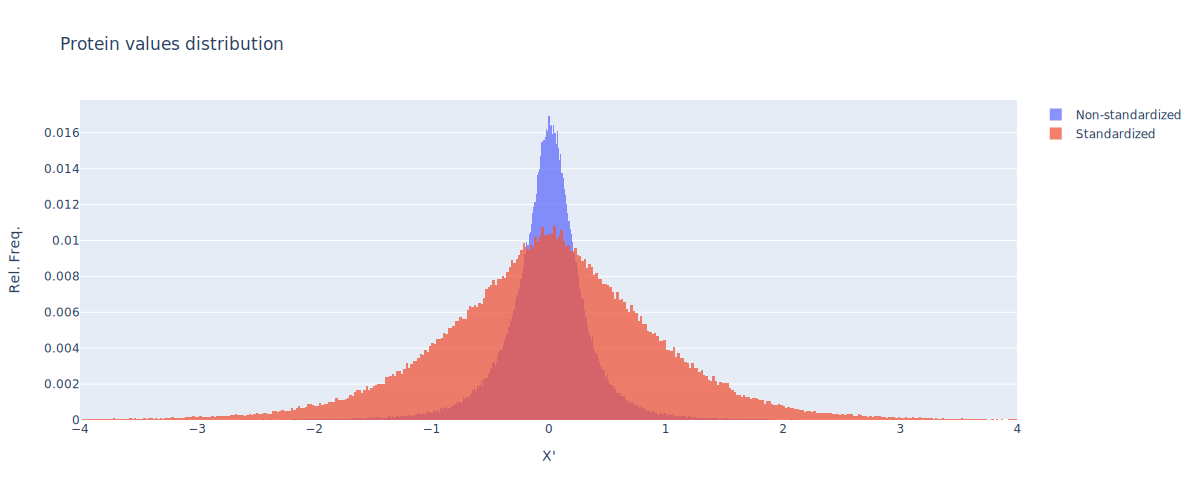

In [35]:
#
# Compare Distribution
#

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=[k for n,i in XqFI.to_dict('list').items() for k in i],
    name='Non-standardized',
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=[k for n,i in XqFIN.to_dict('list').items() for k in i],
    name='Standardized',
    histnorm='probability',
    opacity=0.75
))

fig.update_xaxes(range=[-4, 4])

fig.update_layout(
    title='Protein values distribution',
    width=1200,
    barmode='overlay',
    xaxis_title="X'",
    yaxis_title='Rel. Freq.'
)

fig.show(renderer='svg')